In [1]:
import torch

import numpy as np
import math

from lorenz_setup import (
    sample_delays,
    get_lorenz_stimulation,
    plot_trajectory_and_units,
    animate_activations,
)

from lorenz_settings import (
    N_UNITS,
    MIN_DELAY,
    MAX_DELAY,
    GAMMA,
    DT,
    DELAY_DIST_OFFSET,
    ALPHA,
    BETA,
    LMBDA1,
    LMBDA2,
    LMBDA3,
    U_FACTOR,
    W_FACTOR,
)

from lorenz_simulate import nonlinearity, lateral_inhibition, simulate

import matplotlib.pyplot as plt
import matplotlib

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [3]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

In [4]:
%load_ext autoreload
%autoreload 2

In [21]:
inh_delays = sample_delays(N_UNITS, N_UNITS, max_delay=5, lmbda=0.1)

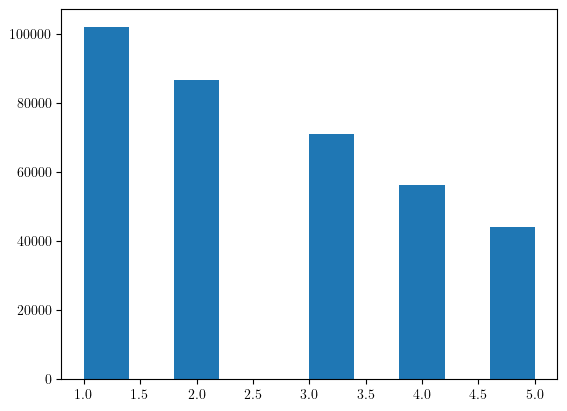

In [8]:
%matplotlib inline
plt.figure()
plt.hist(inh_delays.flatten())
plt.show()

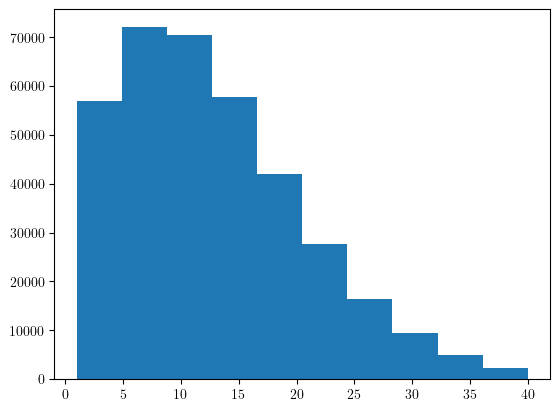

In [7]:
%matplotlib inline
plt.figure()
plt.hist(axonal_delays.flatten())
plt.show()

# Training

In [7]:
sample_states = np.load("checkpoints/sample_states.npy")
unit_locations = np.load("checkpoints/unit_locations.npy")
unit_activation = np.load("checkpoints/unit_activation.npy")
axonal_delays = np.load("checkpoints/axonal_delays.npy")
inh_delays = np.load("checkpoints/inh_delays.npy")

In [6]:
unit_activation.min()

-0.0009149047924989747

In [6]:
axonal_delays.mean(), inh_delays.mean()

(12.648994444444444, 2.593538888888889)

In [11]:
axonal_delays.min(), inh_delays.min()

(1, 1)

In [10]:
axonal_delays.max(), inh_delays.max()

(40, 5)

In [4]:
from threadpoolctl import threadpool_limits

#with threadpool_limits(limits=1):  # otherwise my computer ignites
states, unit_locations, sample_states, unit_activation = get_lorenz_stimulation(
    n_units=N_UNITS,
    duration_placement=2000,
    duration_sample=5000,
    kernel_std=0.5,
    #kernel_std=1.5,
    dt=5e-3,
)

In [5]:
unit_activation -= unit_activation.mean()

In [23]:
np.save("checkpoints/sample_states.npy", sample_states)
np.save("checkpoints/unit_locations.npy", unit_locations)
np.save("checkpoints/unit_activation.npy", unit_activation)
np.save("checkpoints/axonal_delays.npy", axonal_delays)
np.save("checkpoints/inh_delays.npy", inh_delays)

In [8]:
nonlinearity(U_FACTOR * torch.tensor(unit_activation[:10000])).numpy().shape

(10000, 600)

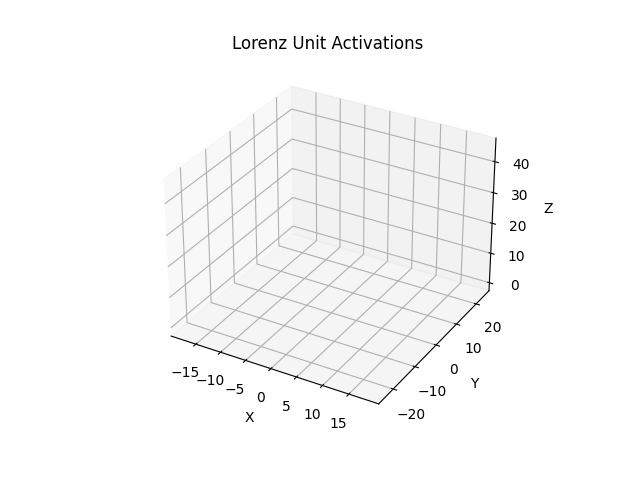

In [3]:
%matplotlib widget
fig, anim = animate_activations(
    unit_locations, sample_states[:10000], nonlinearity(1e4 * torch.tensor(unit_activation[:10000]))
)

In [4]:
plt.close(fig)

In [8]:
def compute_l2_distances(points):
    # Expanding the array dimensions for broadcasting
    # points[:, np.newaxis, :] has shape (n, 1, 3) and points[np.newaxis, :, :] has shape (1, n, 3)
    # Subtracting these arrays results in an array of shape (n, n, 3) containing coordinate-wise differences
    diff = points[:, np.newaxis, :] - points[np.newaxis, :, :]

    # Squaring the differences, summing over the last dimension (coordinate axis), and taking the square root
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))
    #dist_matrix = np.linalg.norm(diff, ord=p, axis=-1)

    return dist_matrix

In [9]:
w_inh = compute_l2_distances(unit_locations)**0.6
#w_inh -= 0.1 * w_inh.mean()
w_inh /= w_inh.mean()

In [10]:
ALPHA, U_FACTOR, LMBDA2, BETA, LMBDA3, GAMMA

(50, 100000.0, 1, 0.001, 100.0, 0.7)

In [11]:
N_STEPS = 1e5

In [12]:
BETA = 1e-3

In [14]:
1/1e-3

1000.0

```python
c_u=1e5, c_w=10, c_inh=0.1, tau_a=7e-1, tau_r=1/50, sigma=0.5,
c_h=8e1, tau_mu=40, mu=0.025, lmbda=1, tau_w=1e3, c_phi=1e2
```

In [458]:
w = 0.001 * np.random.randn(N_UNITS, N_UNITS)
w -= w.mean()
X, w, W, A, fast_A = simulate(unit_activation[:100000], w, axonal_delays, inh_delays,
                      u_factor=1e5, stimulate=1, init_steps=500,
                      lmbda2=1, beta=1e-3, 
                      w_factor=10, alpha=50, gamma=7e-1, lmbda3=8e1, fast_gamma=40, target_activity=0.025,
                      w_inh=w_inh, inh_factor=0.01
                     )

In [459]:
DX = X[1:] - X[:-1]

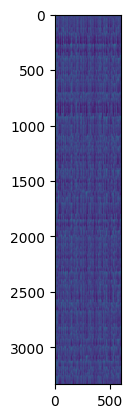

In [460]:
%matplotlib inline
plt.imshow(A[::30])

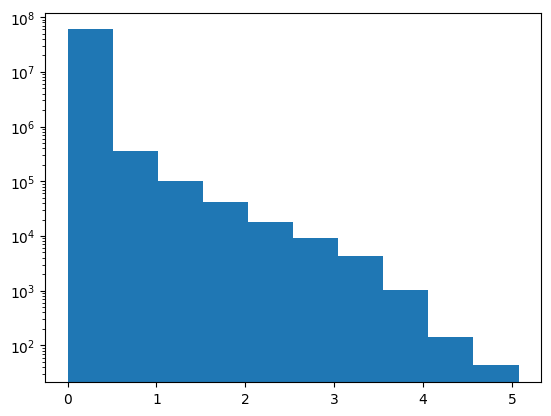

In [461]:
%matplotlib inline
plt.hist(X.flatten())
plt.yscale('log')

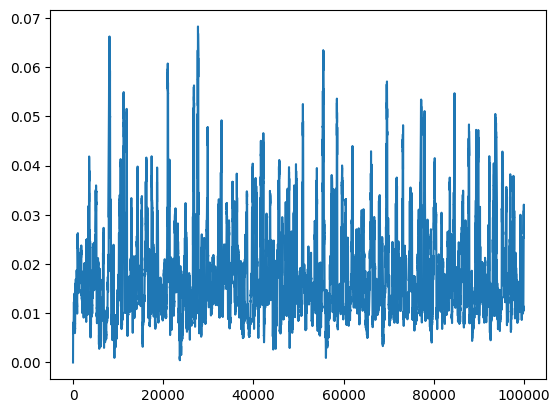

In [462]:
%matplotlib inline
plt.plot(X.mean(1))

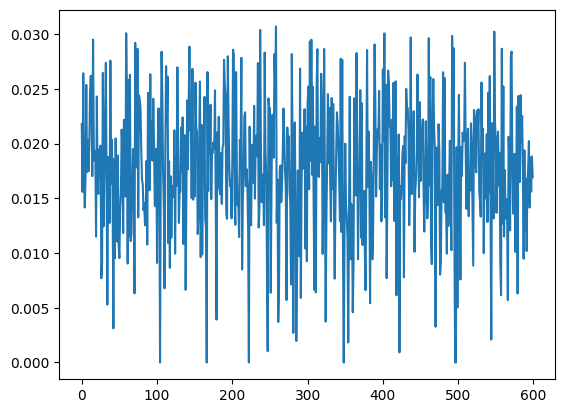

In [463]:
%matplotlib inline
plt.plot(X.mean(0))

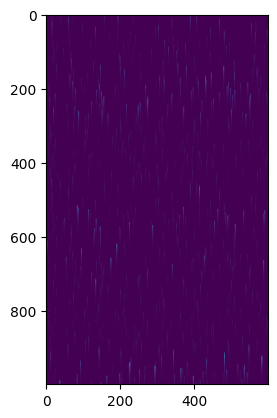

In [464]:
%matplotlib inline
plt.figure()
plt.imshow(X[-1000:])
plt.show()

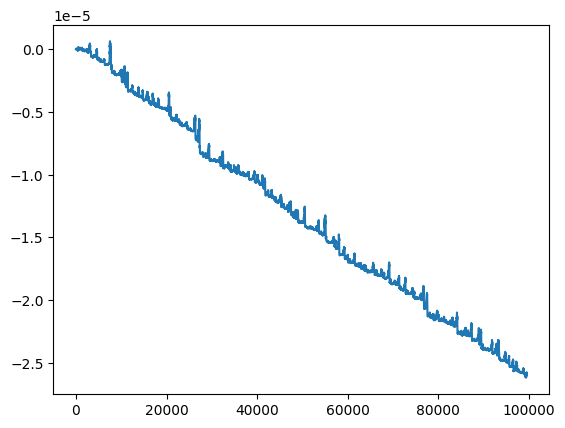

In [465]:
%matplotlib inline
plt.figure()
plt.plot(W)
plt.show()

In [466]:
X.max()

5.074038

In [467]:
w.max()

0.08691475863753692

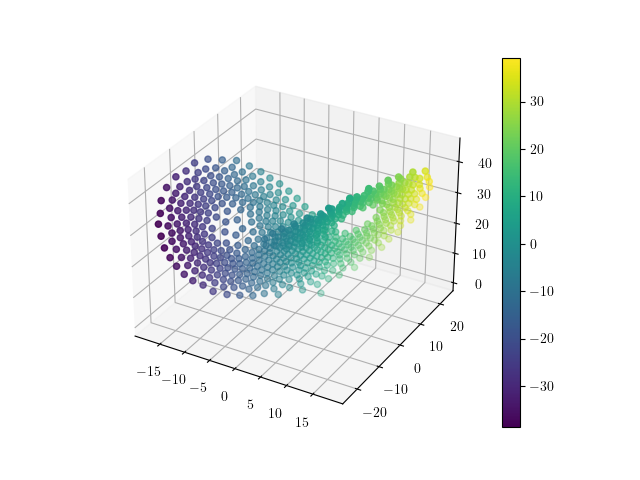

In [1091]:
%matplotlib widget
fig = plot_3d_scatter(unit_locations, unit_locations[:, 0] + unit_locations[:, 1])

In [1092]:
plt.close(fig)

In [13]:
def plot_encode_decode(unit_locations, encode_states, encode_colors, decode_states, decode_colors):
    fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10, 3.5), layout='constrained')

    cm = plt.get_cmap('viridis')
    norm = plt.Normalize(min(decode_colors.min(), encode_colors.min()), max(decode_colors.max(), encode_colors.max()))
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)

    axs[0].computed_zorder = False
    axs[1].computed_zorder = False
    
    ax = axs[0]
    
    units1 = ax.scatter(
        unit_locations[:, 0], unit_locations[:, 1], unit_locations[:, 2], c=encode_colors, alpha=0.1, s=8, cmap=cm, norm=norm
    )
    units1.set_sizes(15 + encode_colors * 30)
    for i in np.argwhere(encode_colors > 0.05).flatten():
        ax.scatter(*unit_locations[i], c=encode_colors[i], cmap=cm, norm=norm,
                   alpha=np.minimum(1, (2*np.abs(encode_colors[i]))), s=15 + encode_colors[i] * 30)

    
    xs, ys, zs = encode_states.T
    segments = 10
    segment_length = len(encode_states)//segments
    for i in range(segments-1):
        start, end = i * segment_length, (i + 1) * segment_length + 1
        ax.plot(xs[start:], ys[start:], zs[start:], c='tab:blue', lw=2, alpha=min(1, 0.0 + 1/segments), zorder=1e4)
    ax.scatter(xs[-1], ys[-1], zs[-1], marker='*', s=8e1, alpha=0.7, c='tab:orange', zorder=1e5, label='encoded state')
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend()

    ax2 = axs[1]
    units2 = ax2.scatter(
        unit_locations[:, 0], unit_locations[:, 1], unit_locations[:, 2], c=decode_colors, alpha=0.1, s=8, cmap=cm, norm=norm
    )
    units2.set_sizes(15 + decode_colors * 30)
    for i in np.argwhere(decode_colors > 0.05).flatten():
        ax2.scatter(*unit_locations[i], c=decode_colors[i], cmap=cm, norm=norm,
                    alpha=np.minimum(1, (2*np.abs(decode_colors[i]))), s=15 + decode_colors[i] * 30)
    
    xs, ys, zs = decode_states.T
    segments = 10
    segment_length = len(decode_states)//segments
    for i in range(segments-1):
        start, end = i * segment_length, (i + 1) * segment_length + 1
        ax2.plot(xs[start:], ys[start:], zs[start:], c='tab:blue', lw=2, alpha=min(1, 0.0 + 1/segments), zorder=1e4)
    ax2.scatter(xs[-1], ys[-1], zs[-1], marker='*', s=8e1, alpha=0.7, c='tab:orange', zorder=1e5, label='decoded state')
    
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("z")
    ax2.legend()

    fig.colorbar(sm, ax=axs, orientation='vertical', label='neural activity', shrink=0.5, pad=0.1)
    plt.savefig('../latex/images/lorenz_encode_decode.pdf', bbox_inches='tight')
    return fig

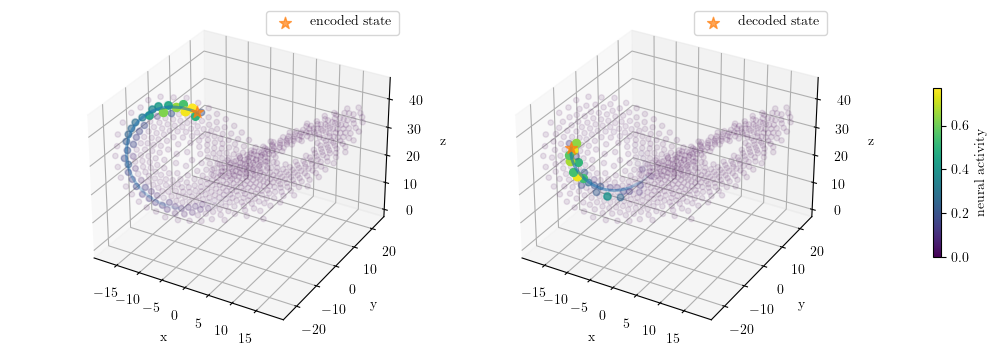

In [1695]:
%matplotlib widget
fig = plot_encode_decode(unit_locations, sample_states[1489-50:1489], X[1489], denoised_decoded_loc[5982-50:5982], X_test[500+5982])

In [1685]:
plt.close('all')

In [14]:
def plot_trajectory_and_units(unit_locations, states):
    segment_length = 100
    xs, ys, zs = states.T
    num_segments = len(xs) // segment_length
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    
    ax.plot(xs[:segment_length + 1], ys[:segment_length + 1], zs[:segment_length + 1], c='tab:blue', lw=0.6, alpha=0.1, label='sample density')
    for i in range(1, num_segments - 1):
        start, end = i * segment_length, (i + 1) * segment_length + 1
        ax.plot(xs[start:end], ys[start:end], zs[start:end], c='tab:blue', lw=0.6, alpha=0.1)
    
    ax.scatter(
        unit_locations[:, 0], unit_locations[:, 1], unit_locations[:, 2], color="tab:orange", alpha=0.6, s=8,
        label='centroid locations'
    )
    #ax.set_title("Lorenz System Trajectory and Unit Positions")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    leg = ax.legend()
    leg.legend_handles[0].set_linewidth(1)
    leg.legend_handles[0].set_alpha(1)
    plt.savefig('../latex/images/lorenz_density_estimation.pdf', bbox_inches='tight')
    return fig

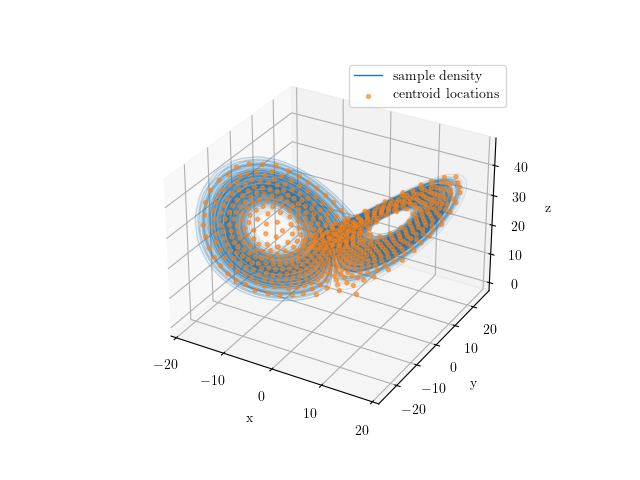

In [1363]:
%matplotlib widget
fig = plot_trajectory_and_units(unit_locations, sample_states[:200000:4])

In [1353]:
plt.close('all')

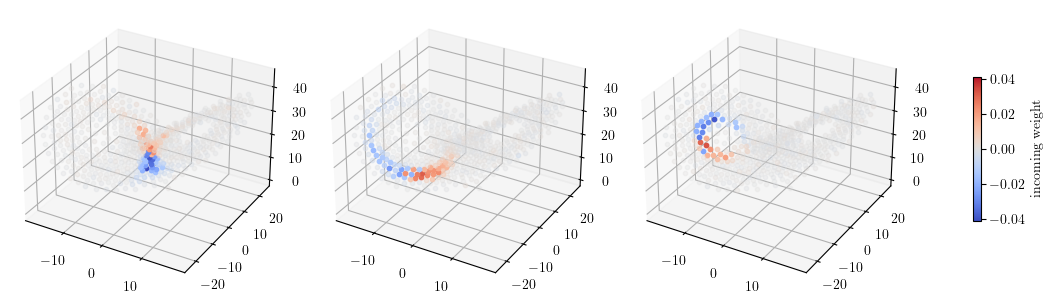

In [1699]:
%matplotlib widget
#9 middle wing
#26 inner wing
#15 between wings split

fig = plot_3d_scatter_shared_colorscale(*unit_locations.T, [w[15], w[9], w[26]])

In [1700]:
plt.close(fig)

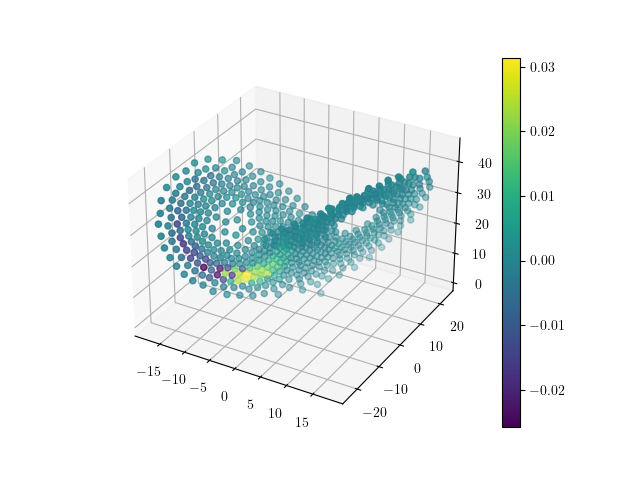

In [1177]:
%matplotlib widget
fig = plot_3d_scatter(unit_locations, w[9])

In [1178]:
plt.close(fig)

In [15]:
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import csr_matrix

In [27]:
new_order = np.argsort(unit_locations[:, 1] + unit_locations[:, 0])

In [21]:
sparse_w = w.copy()
sparse_w[w < np.abs(w).mean()] = 0

In [25]:
new_order = reverse_cuthill_mckee(csr_matrix((sparse_w*1e5).round().astype(int)))

In [23]:
new_order = reverse_cuthill_mckee(csr_matrix((w_inh*1.5).astype(int)))

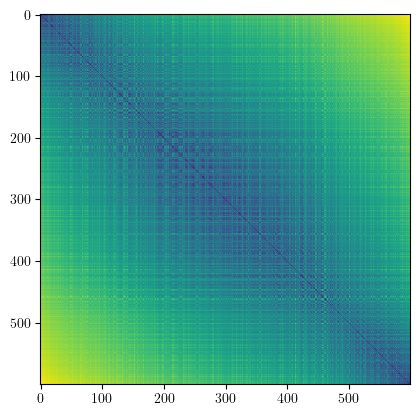

In [1094]:
%matplotlib inline
plt.figure()
plt.imshow(w_inh[:, new_order][new_order])
plt.show()

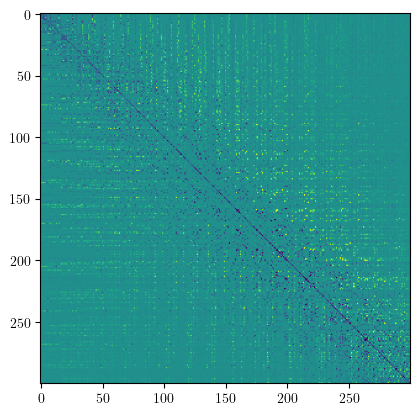

In [29]:
%matplotlib inline
plt.figure()
plt.imshow(w[:, new_order][new_order][:300, :300], vmin=-0.05, vmax=0.05)
plt.show()

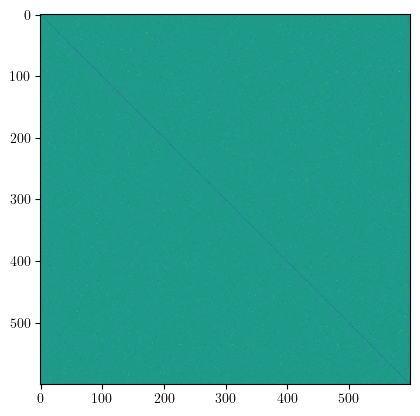

In [30]:
%matplotlib inline
plt.figure()
plt.imshow(w)
plt.show()

In [ ]:
%matplotlib widget
fig, anim = animate_activations(unit_locations, sample_states[-3000:-2000], DX[-3000:-2000])

In [ ]:
plt.close(fig)

In [ ]:
# import matplotlib.animation as animation
# anim.save("awake_lorenz.mp4", writer=animation.FFMpegWriter(fps=60))

In [556]:
import os

if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

# Save the numpy arrays to the "checkpoints" folder
np.save("checkpoints/sample_states.npy", sample_states)
np.save("checkpoints/unit_locations.npy", unit_locations)
np.save("checkpoints/unit_activation.npy", unit_activation)
np.save("checkpoints/axonal_delays.npy", axonal_delays)
np.save("checkpoints/w.npy", w)
np.save("checkpoints/X.npy", X)
np.save("checkpoints/inh_delays.npy", inh_delays)

# Dreaming

In [10]:
def plot_3d_scatter_shared_colorscale(x, y, z, color_sets):
    """
    Plots three 3D scatter plots side by side with different color assignments,
    sharing the same color scale and a single color bar.

    Parameters:
    x, y, z: Arrays or lists of data points for the x, y, z axes.
    color_sets: A list of three arrays, each containing color assignments for the points.
    cmap: The colormap to use for coloring points.
    """
    # Determine the color scale range
    min_color = -max(max(np.abs(colors)) for colors in color_sets)
    max_color = max(max(np.abs(colors)) for colors in color_sets)
    norm = plt.Normalize(min_color, max_color)
    cm = plt.get_cmap('coolwarm')
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)

    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(10.5, 3), layout='constrained')

    for ax, colors in zip(axes, color_sets):
        for i in range(len(x)):
            ax.scatter(x[i], y[i], z[i], c=colors[i], cmap=cm, norm=norm,
                       alpha=np.minimum(1, (0.25+60*np.abs(colors[i]))), s=10)

    # Add a single color bar for all subplots
    #plt.tight_layout()
    fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.5, label='incoming weight')
    plt.savefig('../latex/images/lorenz_weights.pdf', bbox_inches='tight')
    return fig

def plot_3d_scatter(data, colors, cmap='viridis'):
    """
    Plots a 3D scatter plot with colors based on an integer array.

    Parameters:
    x, y, z: Arrays or lists of data points for the x, y, z axes.
    colors: Array of integers from 0 to n-1, for coloring each point.
    n_colors: The number of distinct colors to use.
    cmap: The colormap to use for coloring points.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = data.T

    # Normalize color values to the range of the colormap
    norm = plt.Normalize(colors.min(), colors.max())

    sc = ax.scatter(x, y, z, c=colors, cmap=cmap, norm=norm)
    plt.colorbar(sc)

    return fig

In [ ]:
plot(xs[start:end], ys[start:end], zs[start:end], color=colors[start], linewidth=1.5, alpha=0.25)

In [11]:
def animate_activations(unit_locations, unit_activation, vmax=None, trajectory_data=None):
    if vmax is None:
        vmax = unit_activation.max()
    # Create a new figure
    fig = plt.figure(figsize=(6, 5))

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection="3d")

    # Plot the initial trajectory and unit locations
    if trajectory_data is not None:
        trajectory, = ax.plot([], [], [], lw=2)
    units = ax.scatter(
        unit_locations[:, 0], unit_locations[:, 1], unit_locations[:, 2], c=np.zeros(len(unit_locations)), s=20, vmin=0, vmax=vmax
    )

    # Set the title and labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Function to update the plot for each frame
    def update(i):
        # Update the trajectory
        if trajectory_data is not None:
            trajectory.set_data(trajectory_data[:i+1, 0], trajectory_data[:i+1, 1])
            trajectory.set_3d_properties(trajectory_data[:i+1, 2])

        # Update the unit colors based on their activation state
        units.set_array(unit_activation[i, :])
        units.set_sizes(15 + unit_activation[i, :] * 70)

        #if trajectory is not None:
        #    return trajectory, units
        #else:
        return units

    # Create the animation
    plt.tight_layout()
    anim = FuncAnimation(fig, update, frames=len(unit_activation), interval=3)
    return fig, anim

In [12]:
from scipy.signal import butter, filtfilt

def denoise_timeseries(noisy_data, cutoff_frequency, filter_order):
    """
    Apply a low-pass Butterworth filter to denoise multi-dimensional Lorenz attractor time series data.

    Parameters:
    noisy_data (np.array): The noisy Lorenz attractor time series data with shape (T, 3).
    cutoff_frequency (float): The cutoff frequency for the low-pass filter.
    filter_order (int): The order of the filter.

    Returns:
    np.array: The denoised time series data.
    """
    # Normalize the frequency
    nyquist_frequency = 0.5  # Assuming the sampling rate is 1
    normalized_cutoff = cutoff_frequency / nyquist_frequency

    # Design the Butterworth filter
    b, a = butter(filter_order, normalized_cutoff, btype='low', analog=False)

    # Initialize an array to store the denoised data
    denoised_data = np.zeros_like(noisy_data)

    # Apply the filter to each dimension
    for i in range(noisy_data.shape[1]):
        denoised_data[:, i] = filtfilt(b, a, noisy_data[:, i])

    return denoised_data

In [13]:
def plot_static_trajectory(points):
    segment_length = 100  # number of points per segment

    xs, ys, zs = points.T
    
    num_segments = len(xs) // segment_length
    
    # Get the viridis colormap
    cm = plt.get_cmap('viridis')
    # Normalize the segment indices
    cNorm = plt.Normalize(vmin=0, vmax=len(xs))
    # Get the corresponding colors for each segment
    colors = [cm(cNorm(i)) for i in range(len(xs))]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plotting each segment
    for i in range(num_segments - 1):
        start, end = i * segment_length, (i + 1) * segment_length
        ax.plot(xs[start:end], ys[start:end], zs[start:end], color=colors[start], linewidth=1.5, alpha=0.25)
    
    plt.show()
    return fig

In [14]:
sample_states = np.load("checkpoints/sample_states.npy")
unit_locations = np.load("checkpoints/unit_locations.npy")
unit_activation = np.load("checkpoints/unit_activation.npy")
axonal_delays = np.load("checkpoints/axonal_delays.npy")
w = np.load("checkpoints/w.npy")
X = np.load("checkpoints/X.npy")
inh_delays = np.load("checkpoints/inh_delays.npy")

In [15]:
#X_test_init = X[111234 : 111234 + MAX_DELAY].copy()
#X_test_init = nonlinearity(torch.tensor(unit_activation[:MAX_DELAY])).cpu().numpy()
X_test, w_test, _, A, fast_A = simulate(
    unit_activation[111234 : 111234 + 60000],
    w.copy(),
    axonal_delays,
    inh_delays,
    #w_factor=2000,
    beta=0,
    #X_init=X_test_init,
    #
    #lmbda4=40,
    u_factor=1e5, stimulate=0, init_steps=500,
    w_factor=10, alpha=50, gamma=7e-1, lmbda3=8e1, fast_gamma=40, target_activity=0.025,
    w_inh=w_inh, inh_factor=0.01#4.5*np.abs(w).mean()
)
x_test = X_test[-1].copy()
DX_test = X_test[1:] - X_test[:-1]

In [16]:
start = 500
end = 60000

In [17]:
from scipy.signal import find_peaks, find_peaks_cwt

In [18]:
real_z_peaks = sample_states[111234+start+find_peaks(sample_states[111234+start:111234+end-1, 2])[0], 2][:250]

In [19]:
dx_loc_weights = np.sqrt(np.maximum(DX_test[start:end], 0))

In [20]:
dx_loc_weights = np.sqrt(np.maximum(DX_test[start:end], 0))# + 1e-15 * np.sqrt(X_test[start+1:end])
for i in np.argwhere(dx_loc_weights.mean(1) < 1e-14).flatten():
    dx_loc_weights[i] = dx_loc_weights[i-1].copy()
dx_loc_weights /= dx_loc_weights.sum(1, keepdims=True) + 1e-15
decoded_loc = np.einsum('tn,nd->td', dx_loc_weights, unit_locations)*1.025

In [21]:
denoised_decoded_loc = denoise_timeseries(decoded_loc, 0.055, 2)

In [22]:
z_peak_ids = find_peaks_cwt(denoised_decoded_loc[:, 2], 10)
z_peaks = decoded_loc[z_peak_ids, 2]

In [937]:
len(real_z_peaks)

395

In [938]:
len(z_peaks)

552

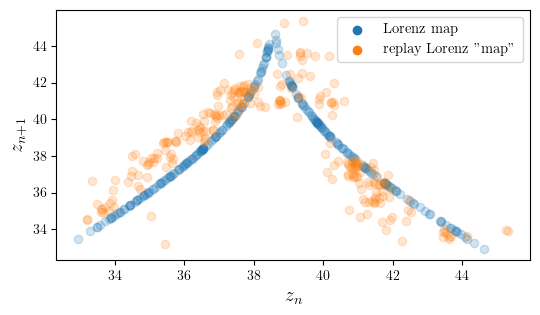

In [45]:
%matplotlib inline
plt.figure(figsize=(5.5, 3.25))
a = 10
plt.scatter(real_z_peaks[:-1], real_z_peaks[1:], alpha=0.2, label='Lorenz map')
plt.scatter(z_peaks[a:a+250-1], z_peaks[1+a:a+250], alpha=0.19, label='replay Lorenz "map"')
#plt.ylim(bottom=32)
plt.xlabel(r'$z_n$', fontsize=14)
plt.ylabel(r'$z_{n+1}$', fontsize=14)
leg = plt.legend(fontsize=10.5)
leg.legend_handles[0].set_alpha(1)
leg.legend_handles[1].set_alpha(1)
plt.tight_layout()
#plt.savefig('../latex/images/lorenz_map.pdf', bbox_inches='tight')
plt.show()

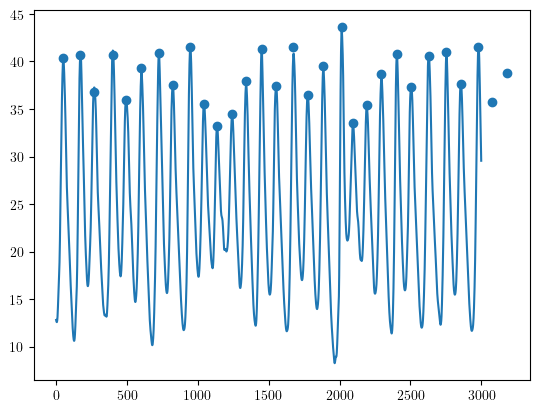

In [948]:
plt.plot(denoised_decoded_loc[:3000, 2])
plt.scatter(z_peak_ids[:30], z_peaks[:30])

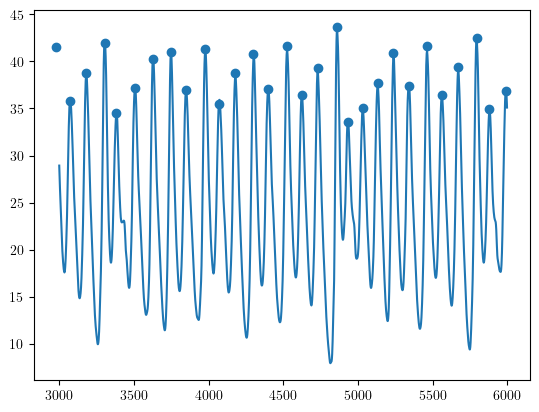

In [949]:
plt.plot(np.arange(3000, 6000), denoised_decoded_loc[3000:6000, 2])
plt.scatter(z_peak_ids[27:56], z_peaks[27:56])

In [23]:
def plot_static_trajectories(points1, points2):
    segment_length = 100  # number of points per segment

    fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10.5, 4), layout='constrained')

    for ax, points in zip(axs, [points1, points2]):
        xs, ys, zs = points.T
        num_segments = len(xs) // segment_length
        
        # Get the viridis colormap
        cm = plt.get_cmap('cividis')
        # Normalize the segment indices
        cNorm = plt.Normalize(vmin=0, vmax=len(xs))
        # Get the corresponding colors for each segment
        colors = [cm(cNorm(i)) for i in range(len(xs))]
        
        # Plotting each segment
        for i in range(num_segments - 1):
            start, end = i * segment_length, (i + 1) * segment_length + 1
            ax.plot(xs[start:end], ys[start:end], zs[start:end], color=colors[start], linewidth=1.5, alpha=0.3)
            ax.set_zlim(10, 45)
            ax.set_ylim(-24, 24)
            ax.set_xlim(-19, 19)
        
        # Setting axis labels
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

    # Adding a common colorbar
    cNorm = plt.Normalize(vmin=0, vmax=len(xs)*DT)
    sm = plt.cm.ScalarMappable(cmap=cm, norm=cNorm)
    sm.set_array([])
    fig.colorbar(sm, ax=axs, orientation='vertical', label='t (seconds)', shrink=0.45, pad=0.1)
    
    # Adjusting the layout and saving the plot
    #plt.tight_layout()
    plt.savefig('../latex/images/lorenz_trajectories.pdf', bbox_inches='tight')

    return fig

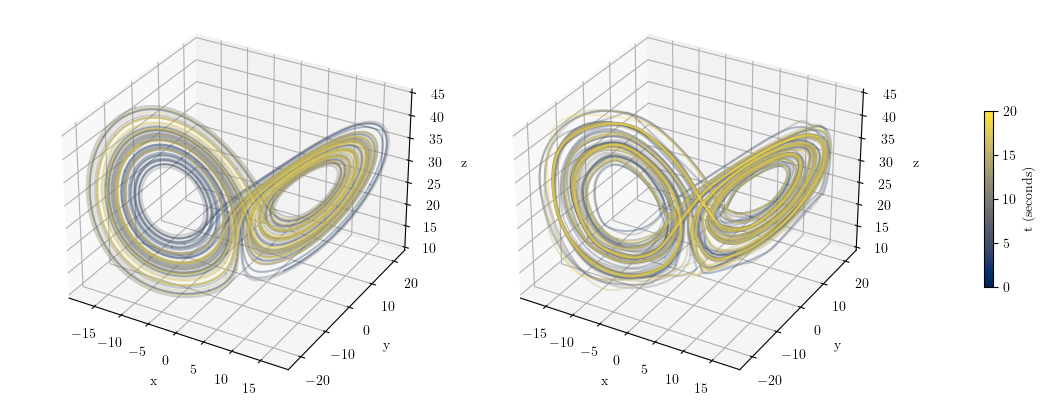

In [50]:
%matplotlib widget
fig = plot_static_trajectories(sample_states[111234+start+15000:111234+start+35000-1], denoised_decoded_loc[15000:35000])

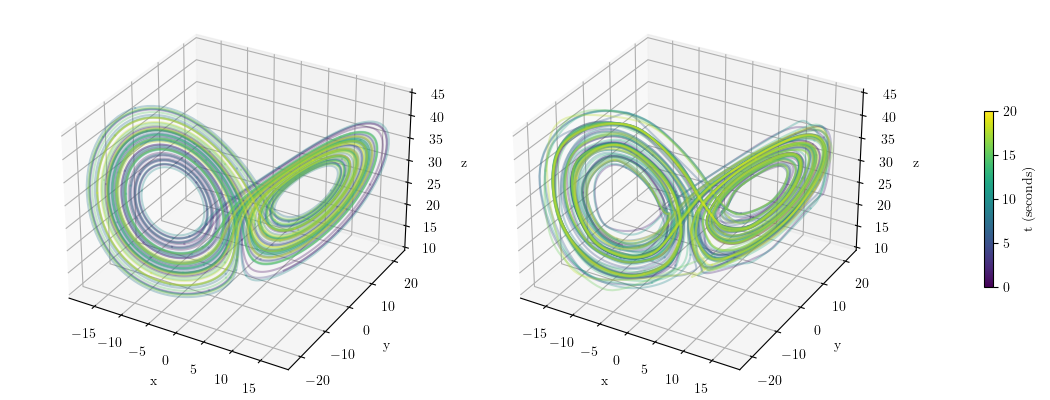

In [1296]:
%matplotlib widget
fig = plot_static_trajectories(sample_states[111234+start+15000:111234+start+35000-1], denoised_decoded_loc[15000:35000])

In [51]:
plt.close(fig)

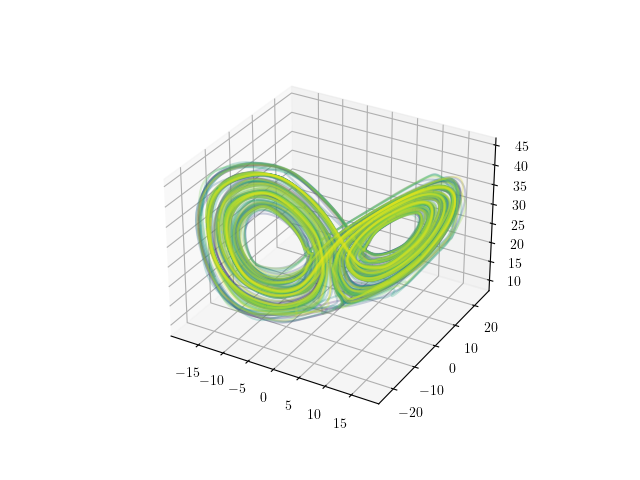

In [827]:
%matplotlib widget
fig = plot_static_trajectory(denoised_decoded_loc[:])

In [828]:
plt.close(fig)

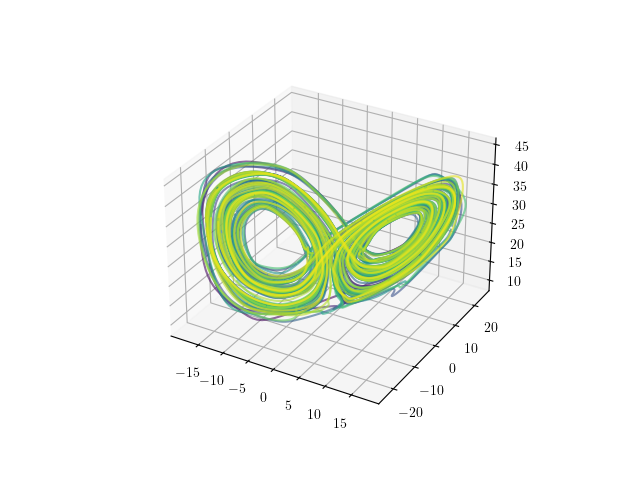

In [810]:
%matplotlib widget
fig = plot_static_trajectory(denoised_decoded_loc[25000:])

In [811]:
plt.close(fig)

In [ ]:
    xs, ys, zs = encode_states.T
    segments = 10
    segment_length = len(encode_states)//segments
    for i in range(segments-1):
        start, end = i * segment_length, (i + 1) * segment_length + 1
        ax.plot(xs[start:], ys[start:], zs[start:], c='tab:blue', lw=2, alpha=min(1, 0.0 + 1/segments), zorder=1e4)


In [180]:
def animate_activations(unit_locations, unit_activation, vmax=None, trajectory_data=None, step_size=1):
    if vmax is None:
        vmax = unit_activation.max()
    # Create a new figure
    fig = plt.figure(figsize=(6, 5))

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection="3d")

    # Plot the initial trajectory and unit locations
    if trajectory_data is not None:
        segments = 10
        segment_length = round(70/step_size)
        trajectories = [(ax.plot([], [], [], lw=2, alpha=min(1, 0.1 + 1/segments), c='tab:blue'))[0] for _ in range(segments)]
    units = ax.scatter(
        unit_locations[:, 0], unit_locations[:, 1], unit_locations[:, 2], c=np.zeros(len(unit_locations)), s=20, vmin=0, vmax=vmax
    )

    # Set the title and labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    # Function to update the plot for each frame
    def update(i):
        # Update the trajectory
        if trajectory_data is not None:
            for s, trajectory in enumerate(trajectories):
                start = max(0, i - segment_length*segments + s * segment_length)*step_size
                end = i*step_size + 1# - segment_length*segments + (s+1) * segment_length
                trajectory.set_data(trajectory_data[start:end, 0], trajectory_data[start:end, 1])
                trajectory.set_3d_properties(trajectory_data[start:end, 2])

        # Update the unit colors based on their activation state
        units.set_array(unit_activation[::step_size][i, :])
        units.set_sizes(20 + np.minimum(unit_activation[::step_size][i, :], 1) * 20)

        #if trajectory is not None:
        #    return trajectory, units
        #else:
        return units

    # Create the animation
    fig.set_tight_layout(True)
    anim = FuncAnimation(fig, update, frames=len(unit_activation[::step_size]), interval=1, blit=True)
    return fig, anim

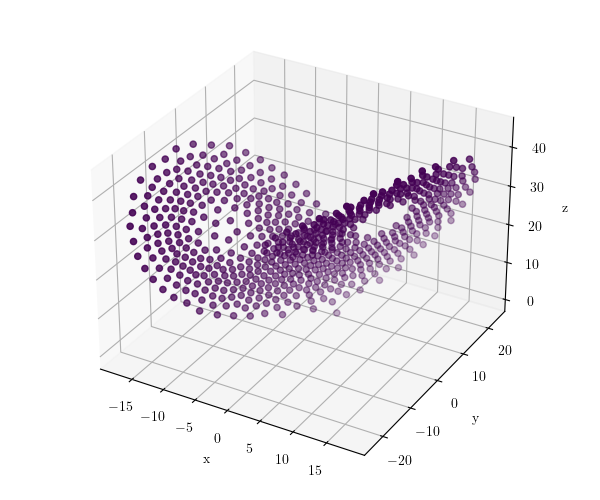

In [181]:
%matplotlib widget
offset = 23400
animation_duration = 4000
fig, anim = animate_activations(
    unit_locations,
    X_test[start+offset:start+offset+animation_duration],
    trajectory_data=denoised_decoded_loc[offset:offset+animation_duration],
    vmax=1,
    step_size=6
)

In [182]:
import matplotlib.animation as animation

anim.save("dreaming_lorenz.mp4", writer=animation.FFMpegWriter(fps=30))

In [183]:
import matplotlib.animation as animation

anim.save("dreaming_lorenz.gif", dpi=100, writer=animation.PillowWriter(fps=30))

In [184]:
plt.close(fig)

In [185]:
from pygifsicle import optimize

optimize("dreaming_lorenz.gif")

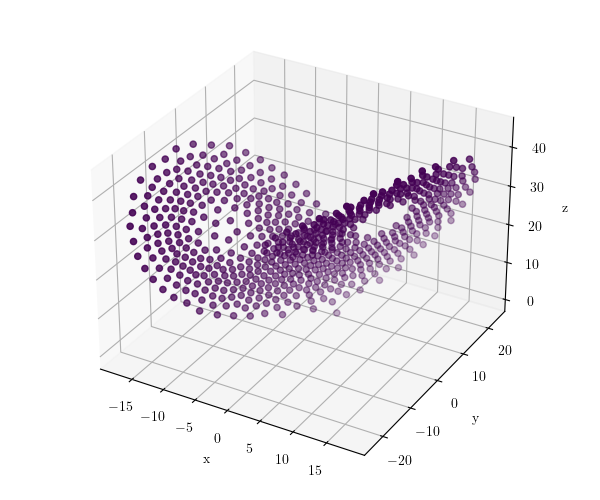

In [186]:
%matplotlib widget
offset = 10000
animation_duration = 4000
fig, anim = animate_activations(
    unit_locations,
    X[offset:offset+animation_duration],
    trajectory_data=sample_states[offset:offset+animation_duration],
    vmax=1,
    step_size=6
)

In [187]:
import matplotlib.animation as animation

anim.save("training_lorenz.mp4", writer=animation.FFMpegWriter(fps=30))

In [188]:
import matplotlib.animation as animation

anim.save("training_lorenz.gif", dpi=100, writer=animation.PillowWriter(fps=30))

In [189]:
plt.close(fig)

In [190]:
from pygifsicle import optimize

optimize("training_lorenz.gif")

In [ ]:
import nolds

In [ ]:
lyap_exp = nolds.lyap_e(data[:, 0], emb_dim=3)
print("Lyapunov Exponent:", lyap_exp)

In [ ]:
corr_dim = nolds.corr_dim(data[:, 0], emb_dim=3)
print("Correlation Dimension:", corr_dim)

In [69]:
anim.save("nena/recurrent_dreaming.gif", fps=60)

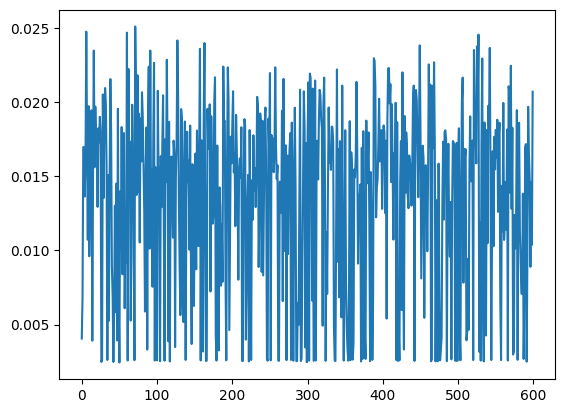

In [147]:
%matplotlib inline
plt.plot(X_test.mean(0))
plt.show()

In [149]:
unit_locations[0]

array([ 6.6638068 ,  2.57941791, 29.879696  ])

In [180]:
np.argwhere(np.linalg.norm(unit_locations - unit_locations[0], axis=1) < 8).flatten()

array([  0,  10,  11,  17,  18,  20,  23,  41,  43,  56,  57,  66,  68,
        77,  78,  88,  94, 109, 114, 116, 123, 128, 131, 132, 134, 137,
       141, 145, 146, 147, 151, 152, 153, 156, 159, 167, 182, 192, 200,
       207, 217, 218, 227, 232, 238, 241, 248, 249, 253, 254, 273, 275,
       276, 293, 300, 302, 306, 316, 326, 327, 329, 349, 350, 356, 370,
       372, 378, 394, 401, 410, 417, 419, 421, 425, 434, 447, 452, 453,
       473, 474, 475, 501, 502, 508, 512, 513, 515, 522, 531, 540, 549,
       550, 559, 562, 573, 578, 584, 594])

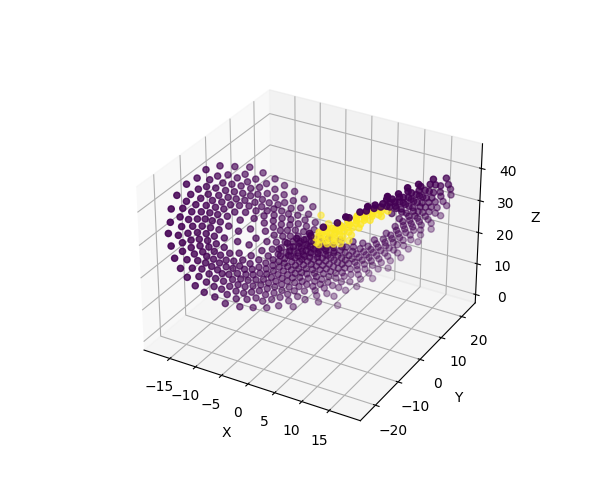

In [183]:
%matplotlib widget

fig = plt.figure(figsize=(6, 5))

# Add a 3D subplot
ax = fig.add_subplot(111, projection="3d")

a = np.zeros(N_UNITS)
a[np.argwhere(np.linalg.norm(unit_locations - unit_locations[0], axis=1) < 8).flatten()] = 1
# Plot the initial trajectory and unit locations
# trajectory, = ax.plot([], [], [], lw=0.5)
units = ax.scatter(
    unit_locations[:, 0], unit_locations[:, 1], unit_locations[:, 2],
    c=a, s=20, vmin=0, vmax=1
)

# Set the title and labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [184]:
plt.close(fig)

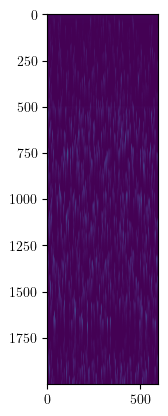

In [699]:
%matplotlib inline
plt.figure()
plt.imshow(fast_A[:2000:1])
plt.show()

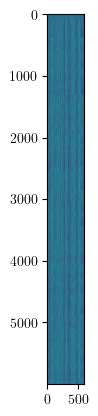

In [700]:
%matplotlib inline
plt.figure()
plt.imshow(A[::10])
plt.show()

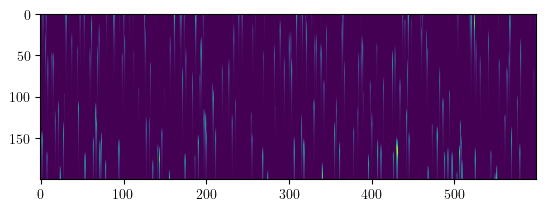

In [701]:
%matplotlib inline
plt.figure()
plt.imshow(X_test[800:1000:1])
plt.show()

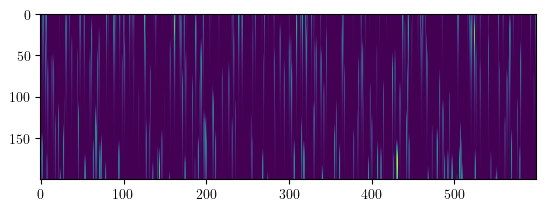

In [702]:
%matplotlib inline
plt.figure()
plt.imshow(fast_A[800:1000:1])
plt.show()

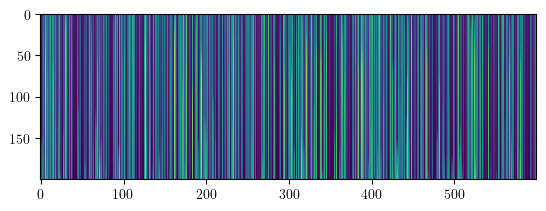

In [703]:
%matplotlib inline
plt.figure()
plt.imshow(A[800:1000:1])
plt.show()

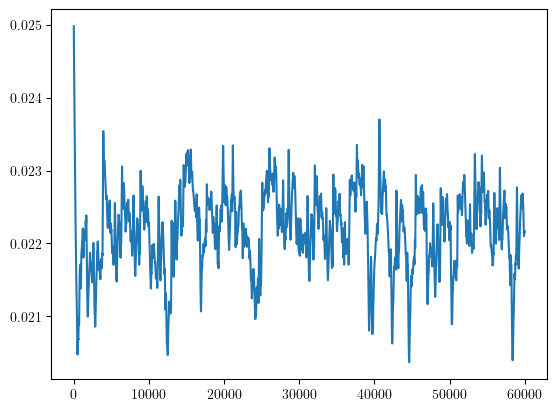

In [704]:
%matplotlib inline
plt.figure()
plt.plot(A.mean(1))

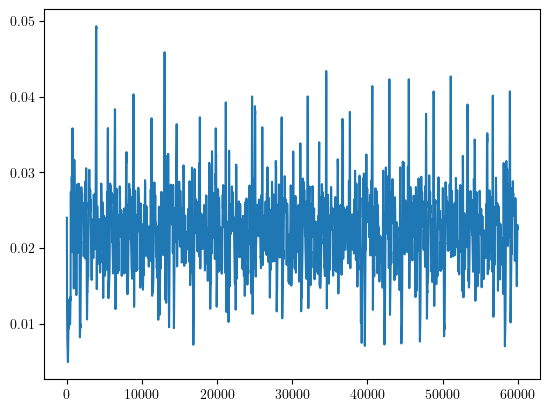

In [705]:
plt.plot(fast_A.mean(1))

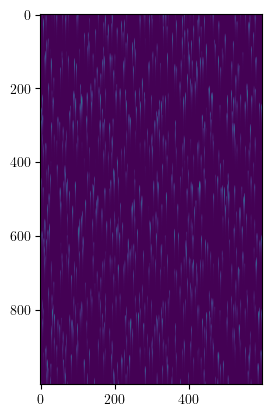

In [706]:
%matplotlib inline
plt.figure()
plt.imshow(X_test[500:1500])  # , vmin=X.min(), vmax=X.max())
plt.show()

(array([12., 28., 62., 99., 98., 99., 77., 63., 40., 22.]),
 array([ 0.        ,  3.40190985,  6.80381971, 10.20572956, 13.60763941,
        17.00954927, 20.41145912, 23.81336898, 27.21527883, 30.61718868,
        34.01909854]),
 <BarContainer object of 10 artists>)

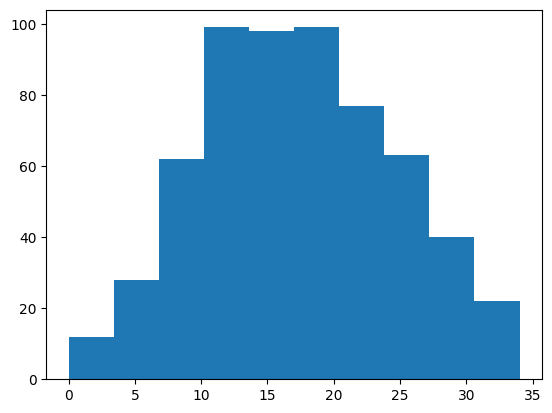

In [177]:
plt.hist(np.linalg.norm(unit_locations - unit_locations[0], axis=1))

In [164]:
top_loc = unit_locations[DX_test.argmax(1)]

In [165]:
dtop_loc = top_loc[1:] - top_loc[:-1]

(array([4.430e+04, 4.188e+03, 8.100e+02, 3.240e+02, 1.070e+02, 8.800e+01,
        3.900e+01, 5.100e+01, 5.400e+01, 3.700e+01]),
 array([ 0.        ,  5.48547676, 10.97095352, 16.45643028, 21.94190703,
        27.42738379, 32.91286055, 38.39833731, 43.88381407, 49.36929083,
        54.85476759]),
 <BarContainer object of 10 artists>)

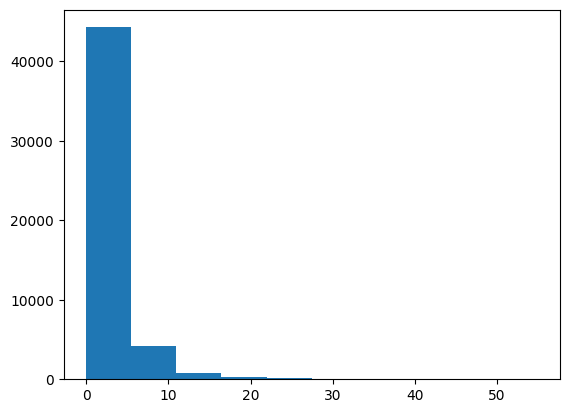

In [172]:
plt.hist(np.linalg.norm(dtop_loc, axis=1))
#plt.yscale('log')

In [203]:
neighbours = {}
for i in range(N_UNITS):
    neighbours[i] = np.argwhere(np.linalg.norm(unit_locations - unit_locations[i], axis=1) < 8).flatten()

In [ ]:
111234 : 111234 + MAX_DELAY

In [189]:
sample_states[111234 + MAX_DELAY]

array([-1.84963888, -3.22243386, 11.6669464 ])

In [190]:
state = sample_states[111234]

In [192]:
len(X_test)

50000

In [207]:
X_test.shape

(50000, 600)

In [220]:
X_test[100, neighbours[102]].mean()

0.00080320897

In [43]:
import matplotlib.animation as animation

anim.save("dreaming_lorenz.mp4", writer=animation.FFMpegWriter(fps=60))